In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

In [7]:
import pandas as pd

df_ce = pd.read_csv('Carbon Emissions.csv')

# Check for missing values
total_missing = df_ce.isnull().sum().sum()
total_cells = df_ce.size
missing_percentage = (total_missing / total_cells) * 100 if total_cells > 0 else 0

print(f"Total missing values: {total_missing}")
print(f"Percentage of missing data: {missing_percentage:.2f}%")

# Missing values per column
missing_per_column = df_ce.isnull().sum()
missing_percentage_per_column = (missing_per_column / len(df_ce)) * 100

print("\nMissing values per column:")
columns_with_missing = missing_per_column[missing_per_column > 0]
if not columns_with_missing.empty:
    for col in columns_with_missing.index:
        print(f"{col}: {missing_per_column[col]} ({missing_percentage_per_column[col]:.2f}%)")
else:
    print("No missing values found in any column.")

# Display dataset info
print("\nDataset info:")
df_ce.info()

Total missing values: 2165
Percentage of missing data: 0.03%

Missing values per column:
Country Code: 433 (0.08%)
Region Code: 433 (0.08%)
Second Tier Authority: 433 (0.08%)
Mid-year Population (thousands): 433 (0.08%)
Area (km2): 433 (0.08%)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559215 entries, 0 to 559214
Data columns (total 15 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   Country                                                  559215 non-null  object 
 1   Country Code                                             558782 non-null  object 
 2   Region                                                   559215 non-null  object 
 3   Region Code                                              558782 non-null  object 
 4   Second Tier Authority                                    558782 non-null  object 
 5   Local Authority 

In [8]:
# Prepare long/tidy dataframe (df_ce is already in long-ish form for this dataset).
# Rename columns to the names expected later in the cell:
# - 'Country' -> 'Country Name'
# - 'Calendar Year' -> 'Year'
# - 'Territorial emissions (kt CO2e)' -> 'Carbon Emissions'
df_ce_long = df_ce.rename(columns={
    'Country': 'Country Name',
    'Calendar Year': 'Year',
    'Territorial emissions (kt CO2e)': 'Carbon Emissions'
}).copy()

# Ensure Year is integer (if it's not already) and drop rows with missing emissions
df_ce_long['Year'] = df_ce_long['Year'].astype(int)
df_ce_long = df_ce_long.dropna(subset=['Carbon Emissions'])

# Basic EDA: summaries and example visualisations
# Descriptive stats
print('Descriptive statistics for Carbon Emissions (overall):')
display(df_ce_long['Carbon Emissions'].describe())

# Number of unique countries and years
print('Unique countries:', df_ce_long['Country Name'].nunique())
print('Year range:', df_ce_long['Year'].min(), '-', df_ce_long['Year'].max())

Descriptive statistics for Carbon Emissions (overall):


count    559215.000000
mean         17.014523
std          96.373894
min       -2785.525329
25%           0.044687
50%           0.537728
75%           5.200877
max       10927.385820
Name: Carbon Emissions, dtype: float64

Unique countries: 5
Year range: 2005 - 2023


SECTOR-LEVEL PREDICTION ANALYSIS: 2005-2024

--------------------------------------------------------------------------------
STEP 1: IDENTIFYING TOP 3 SECTORS (2005-2024)
--------------------------------------------------------------------------------

Using 'LA GHG Sector' column for sector analysis

Top 3 Sectors by Total Emissions (2005-2024):
  1. Transport: 2,414,889 kt CO2e
  2. Domestic: 2,307,288 kt CO2e
  3. Industry: 1,795,605 kt CO2e

Total unique sectors: 8


,LA GHG Sector,Carbon Emissions
6,Transport,2.414889e+06
2,Domestic,2.307288e+06
3,Industry,1.795605e+06
1,Commercial,1.058676e+06
0,Agriculture,9.885362e+05
7,Waste,5.873942e+05
5,Public Sector,3.464022e+05
4,LULUCF,1.598567e+04


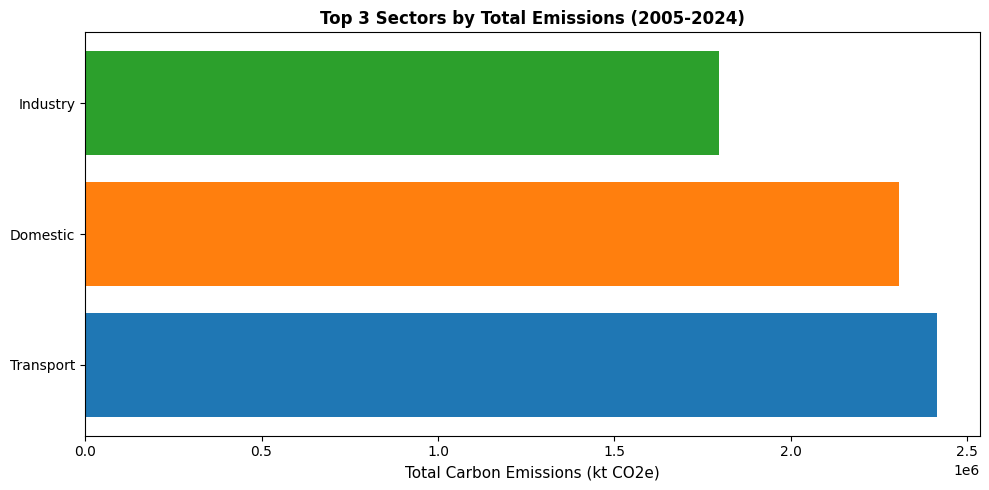

In [9]:
# ============================================================================
# SECTOR-LEVEL PREDICTION ANALYSIS (2005-2024)
# Which model predicts Top 3 sectors best?
# ============================================================================

print("="*80)
print("SECTOR-LEVEL PREDICTION ANALYSIS: 2005-2024")
print("="*80)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import warnings

from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

# Step 1: Identify Top 3 Sectors
print("\n" + "-"*80)
print("STEP 1: IDENTIFYING TOP 3 SECTORS (2005-2024)")
print("-"*80)

# Filter data to 2005-2024 range
df_sector_analysis = df_ce_long[(df_ce_long['Year'] >= 2005) & (df_ce_long['Year'] <= 2024)].copy()
df_sector_analysis['Carbon Emissions'] = pd.to_numeric(df_sector_analysis['Carbon Emissions'], errors='coerce')

# Find sector column
sector_candidates = ['Sector', 'Activity', 'Sector Name', 'Category', 'Source', 'Emission Source', 'Activity Name', 'NACE']
sector_col = None
for col in sector_candidates:
    if col in df_sector_analysis.columns:
        sector_col = col
        break

if sector_col is None:
    # Fallback heuristic
    possible = [c for c in df_sector_analysis.columns if any(k in c.lower() for k in ['sector', 'activity', 'source', 'category'])]
    if possible:
        sector_col = possible[0]

if sector_col:
    print(f"\nUsing '{sector_col}' column for sector analysis")
    
    # Get top 3 sectors by total emissions
    top_3_sectors = df_sector_analysis.groupby(sector_col, as_index=False)['Carbon Emissions'].sum() \
                    .sort_values('Carbon Emissions', ascending=False).head(3)
    
    # Identify top 3 sectors by total emissions from 2005-2024 for focused analysis
    top_3_names = top_3_sectors[sector_col].values
    
    print("\nTop 3 Sectors by Total Emissions (2005-2024):")
    for idx, (_, row) in enumerate(top_3_sectors.iterrows(), 1):
        print(f"  {idx}. {row[sector_col]}: {row['Carbon Emissions']:,.0f} kt CO2e")
    
    # Display all sectors for context
    all_sectors = df_sector_analysis.groupby(sector_col, as_index=False)['Carbon Emissions'].sum() \
                  .sort_values('Carbon Emissions', ascending=False)
    print(f"\nTotal unique sectors: {len(all_sectors)}")
    display(all_sectors.head(10))
    
    # Plot top 3 sectors
    plt.figure(figsize=(10, 5))
    plt.barh(top_3_sectors[sector_col], top_3_sectors['Carbon Emissions'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.xlabel('Total Carbon Emissions (kt CO2e)', fontsize=11)
    plt.title('Top 3 Sectors by Total Emissions (2005-2024)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

# Ensure sector_col is defined
sector_col = 'LA GHG Sector'

# Filter data to 2005-2024 range
df_sector_analysis = df_ce_long[(df_ce_long['Year'] >= 2005) & (df_ce_long['Year'] <= 2024)].copy()
df_sector_analysis['Carbon Emissions'] = pd.to_numeric(df_sector_analysis['Carbon Emissions'], errors='coerce')

# Get top 3 sectors by total emissions
top_3_sectors = df_sector_analysis.groupby(sector_col, as_index=False)['Carbon Emissions'].sum() \
                .sort_values('Carbon Emissions', ascending=False).head(3)

# Get top 3 sector names from the sector analysis in the previous cell
top_3_names = top_3_sectors[sector_col].values

# ============================================================================
# MANUAL PARAMETER TUNING - Modify these values for each sector
# (Define after top_3_names is available)
# ============================================================================
sector_params = {
    top_3_names[0]: {  # First sector (usually Transport)
        'arima_order': (4, 2, 1),
        'rf_n_estimators': 100,
        'rf_max_depth': 7,
        'xgb_n_estimators': 100,
        'xgb_max_depth': 10,
        'xgb_learning_rate': 0.1
    },
    top_3_names[1]: {  # Second sector (usually Domestic)
        'arima_order': (3, 1, 2),
        'rf_n_estimators': 100,
        'rf_max_depth': 7,
        'xgb_n_estimators': 100,
        'xgb_max_depth': 6,
        'xgb_learning_rate': 0.1
    },
    top_3_names[2]: {  # Third sector (usually Industry)
        'arima_order': (3, 1, 2),
        'rf_n_estimators': 100,
        'rf_max_depth': 7,
        'xgb_n_estimators': 100,
        'xgb_max_depth': 6,
        'xgb_learning_rate': 0.1
    }
}

print("\n" + "="*80)
print("MANUAL PARAMETER CONFIGURATION")
print("="*80)
print("\nSector-specific parameters set:")
for sector, params in sector_params.items():
    print(f"\n{sector}:")
    print(f"  ARIMA: order={params['arima_order']}")
    print(f"  Random Forest: n_estimators={params['rf_n_estimators']}, max_depth={params['rf_max_depth']}")
    print(f"  XGBoost: n_estimators={params['xgb_n_estimators']}, max_depth={params['xgb_max_depth']}, learning_rate={params['xgb_learning_rate']}")


# Function to evaluate model
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# Create sector_ts_data dictionary
sector_ts_data = {}
for sector in top_3_names:
    sector_ts_data[sector] = df_sector_analysis[df_sector_analysis[sector_col] == sector][['Year', 'Carbon Emissions']].copy()

# Results storage
results = []

# ============================================================================
# MODEL 1: ARIMA - Tune for each sector separately
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: ARIMA - Tuning for each sector")
print("="*80)

arima_results = {}
for sector in top_3_names:
    print(f"\n{'─'*80}")
    print(f"Tuning ARIMA for Sector: {sector}")
    arima_order = sector_params[sector]['arima_order']
    print(f"Using manual ARIMA order: {arima_order}")

    # prepare train/test split for this sector (time-based)
    sector_data = sector_ts_data[sector].sort_values('Year')
    split_year = int(sector_data['Year'].quantile(0.8))
    train = sector_data[sector_data['Year'] <= split_year]
    test = sector_data[sector_data['Year'] > split_year]
    y_train = train['Carbon Emissions']
    y_test = test['Carbon Emissions']

    try:
        arima_model = ARIMA(y_train, order=arima_order).fit()
        print(f"✓ Model fitted successfully (AIC: {arima_model.aic:.2f})")
    except Exception as e:
        print(f"✗ Error with order {arima_order}: {str(e)[:200]}")
        print("  Using fallback order (1,1,1)")
        arima_model = ARIMA(y_train, order=(1,1,1)).fit()
        arima_order = (1,1,1)

    arima_pred = arima_model.forecast(steps=len(y_test))
    arima_r2, arima_rmse, arima_mae = evaluate_model(y_test, arima_pred)

    print(f"  Performance: R² = {arima_r2:.4f}, RMSE = {arima_rmse:.2f}, MAE = {arima_mae:.2f}")

    arima_results[sector] = {
        'R2': arima_r2,
        'RMSE': arima_rmse,
        'MAE': arima_mae,
        'Best_Order': arima_order
    }

# ============================================================================
# MODEL 2: Random Forest - Tune for each sector separately
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: Random Forest - Tuning for each sector")
print("="*80)

rf_results = {}
for sector in top_3_names:
    print(f"\n{'─'*80}")
    print(f"Tuning Random Forest for Sector: {sector}")
    print(f"{'─'*80}")

    sector_data = sector_ts_data[sector].sort_values('Year')
    split_year = int(sector_data['Year'].quantile(0.8))
    train = sector_data[sector_data['Year'] <= split_year]
    test = sector_data[sector_data['Year'] > split_year]
    X_train = train[['Year']]
    y_train = train['Carbon Emissions']
    X_test = test[['Year']]
    y_test = test['Carbon Emissions']

    # Tune Random Forest for this sector
    print(f"Training Random Forest for Sector: {sector}")
    rf_param_grid = {
        'max_depth': [None, 10, 20]
    }

    print(f"Testing parameter grid: {rf_param_grid}")
    rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=0)
    rf_grid.fit(X_train, y_train)
    rf_model = rf_grid.best_estimator_

    print(f"✓ Best parameters for {sector}: {rf_grid.best_params_}")
    print(f"\n{'─'*80}")
    # Use manually specified Random Forest parameters from sector_params
    rf_n_estimators = sector_params[sector]['rf_n_estimators']
    rf_max_depth = sector_params[sector]['rf_max_depth']
    print(f"Using manual parameters: n_estimators={rf_n_estimators}, max_depth={rf_max_depth}")

    rf_model = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    print(f"✓ Model trained successfully")

    rf_pred = rf_model.predict(X_test)
    rf_r2, rf_rmse, rf_mae = evaluate_model(y_test, rf_pred)

    print(f"  Performance: R² = {rf_r2:.4f}, RMSE = {rf_rmse:.2f}, MAE = {rf_mae:.2f}")

    rf_results[sector] = {
        'R2': rf_r2,
        'RMSE': rf_rmse,
        'MAE': rf_mae,
        'Best_Params': {'n_estimators': rf_n_estimators, 'max_depth': rf_max_depth}
    }

# ============================================================================
# MODEL 3: XGBoost - Tune for each sector separately
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: XGBoost - Tuning for each sector")
print("="*80)

xgb_results = {}
for sector in top_3_names:
    print(f"\n{'─'*80}")
    print(f"Tuning XGBoost for Sector: {sector}")
    print(f"Training XGBoost for Sector: {sector}")

    sector_data = sector_ts_data[sector].sort_values('Year')
    split_year = int(sector_data['Year'].quantile(0.8))
    train = sector_data[sector_data['Year'] <= split_year]
    test = sector_data[sector_data['Year'] > split_year]
    X_train = train[['Year']]
    y_train = train['Carbon Emissions']
    X_test = test[['Year']]
    y_test = test['Carbon Emissions']

    # Use manually specified XGBoost parameters from sector_params
    xgb_n_estimators = sector_params[sector]['xgb_n_estimators']
    xgb_max_depth = sector_params[sector]['xgb_max_depth']
    xgb_learning_rate = sector_params[sector]['xgb_learning_rate']
    print(f"Using manual parameters: n_estimators={xgb_n_estimators}, max_depth={xgb_max_depth}, learning_rate={xgb_learning_rate}")

    xgb_model = XGBRegressor(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        random_state=42,
        verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    print(f"✓ Model trained successfully")
    xgb_pred = xgb_model.predict(X_test)
    xgb_r2, xgb_rmse, xgb_mae = evaluate_model(y_test, xgb_pred)

    print(f"  Performance: R² = {xgb_r2:.4f}, RMSE = {xgb_rmse:.2f}, MAE = {xgb_mae:.2f}")

    xgb_results[sector] = {
        'R2': xgb_r2,
        'RMSE': xgb_rmse,
        'MAE': xgb_mae,
        'Best_Params': {'n_estimators': xgb_n_estimators, 'max_depth': xgb_max_depth, 'learning_rate': xgb_learning_rate}
    }

# ============================================================================
# CONSOLIDATED RESULTS
# ============================================================================
print("\n" + "="*80)
print("CONSOLIDATED RESULTS - All Models by Sector")
print("="*80)

for sector in top_3_names:
    results.append({
        'Sector': sector,
        'ARIMA_R2': arima_results[sector]['R2'],
        'ARIMA_RMSE': arima_results[sector]['RMSE'],
        'ARIMA_MAE': arima_results[sector]['MAE'],
        'RF_R2': rf_results[sector]['R2'],
        'RF_RMSE': rf_results[sector]['RMSE'],
        'RF_MAE': rf_results[sector]['MAE'],
        'XGB_R2': xgb_results[sector]['R2'],
        'XGB_RMSE': xgb_results[sector]['RMSE'],
        'XGB_MAE': xgb_results[sector]['MAE']
    })

# Display results
perf_df = pd.DataFrame(results)
print("\nPerformance Summary:")
display(perf_df)

# Overall comparison (average across sectors)
print("\n" + "="*80)
print("AVERAGE PERFORMANCE ACROSS ALL SECTORS")
print("="*80)

avg_scores = {
    'ARIMA': perf_df[['ARIMA_R2', 'ARIMA_RMSE', 'ARIMA_MAE']].mean().values,
    'Random Forest': perf_df[['RF_R2', 'RF_RMSE', 'RF_MAE']].mean().values,
    'XGBoost': perf_df[['XGB_R2', 'XGB_RMSE', 'XGB_MAE']].mean().values
}

for model, scores in avg_scores.items():
    print(f"\n{model}:")
    print(f"  Average R² = {scores[0]:.4f}")
    print(f"  Average RMSE = {scores[1]:.2f}")
    print(f"  Average MAE = {scores[2]:.2f}")


MANUAL PARAMETER CONFIGURATION

Sector-specific parameters set:

Transport:
  ARIMA: order=(4, 2, 1)
  Random Forest: n_estimators=100, max_depth=7
  XGBoost: n_estimators=100, max_depth=10, learning_rate=0.1

Domestic:
  ARIMA: order=(3, 1, 2)
  Random Forest: n_estimators=100, max_depth=7
  XGBoost: n_estimators=100, max_depth=6, learning_rate=0.1

Industry:
  ARIMA: order=(3, 1, 2)
  Random Forest: n_estimators=100, max_depth=7
  XGBoost: n_estimators=100, max_depth=6, learning_rate=0.1

MODEL 1: ARIMA - Tuning for each sector

────────────────────────────────────────────────────────────────────────────────
Tuning ARIMA for Sector: Transport
Using manual ARIMA order: (4, 2, 1)
✓ Model fitted successfully (AIC: 892649.37)
  Performance: R² = -0.0004, RMSE = 60.36, MAE = 36.52

────────────────────────────────────────────────────────────────────────────────
Tuning ARIMA for Sector: Domestic
Using manual ARIMA order: (3, 1, 2)
✓ Model fitted successfully (AIC: 607140.12)
  Performance

,Sector,ARIMA_R2,ARIMA_RMSE,ARIMA_MAE,RF_R2,RF_RMSE,RF_MAE,XGB_R2,XGB_RMSE,XGB_MAE
0,Transport,-0.000389,60.362086,36.520613,-0.000601,60.368480,34.871884,-0.000631,60.369387,34.848972
1,Domestic,-0.000134,63.458374,38.334812,-0.000283,63.463115,38.539373,-0.000232,63.461488,38.486487
2,Industry,-0.004185,133.105332,28.725305,-0.000006,132.828047,22.504243,-0.000001,132.827765,22.606115



AVERAGE PERFORMANCE ACROSS ALL SECTORS

ARIMA:
  Average R² = -0.0016
  Average RMSE = 85.64
  Average MAE = 34.53

Random Forest:
  Average R² = -0.0003
  Average RMSE = 85.55
  Average MAE = 31.97

XGBoost:
  Average R² = -0.0003
  Average RMSE = 85.55
  Average MAE = 31.98



VISUALIZING MODEL PERFORMANCE COMPARISON


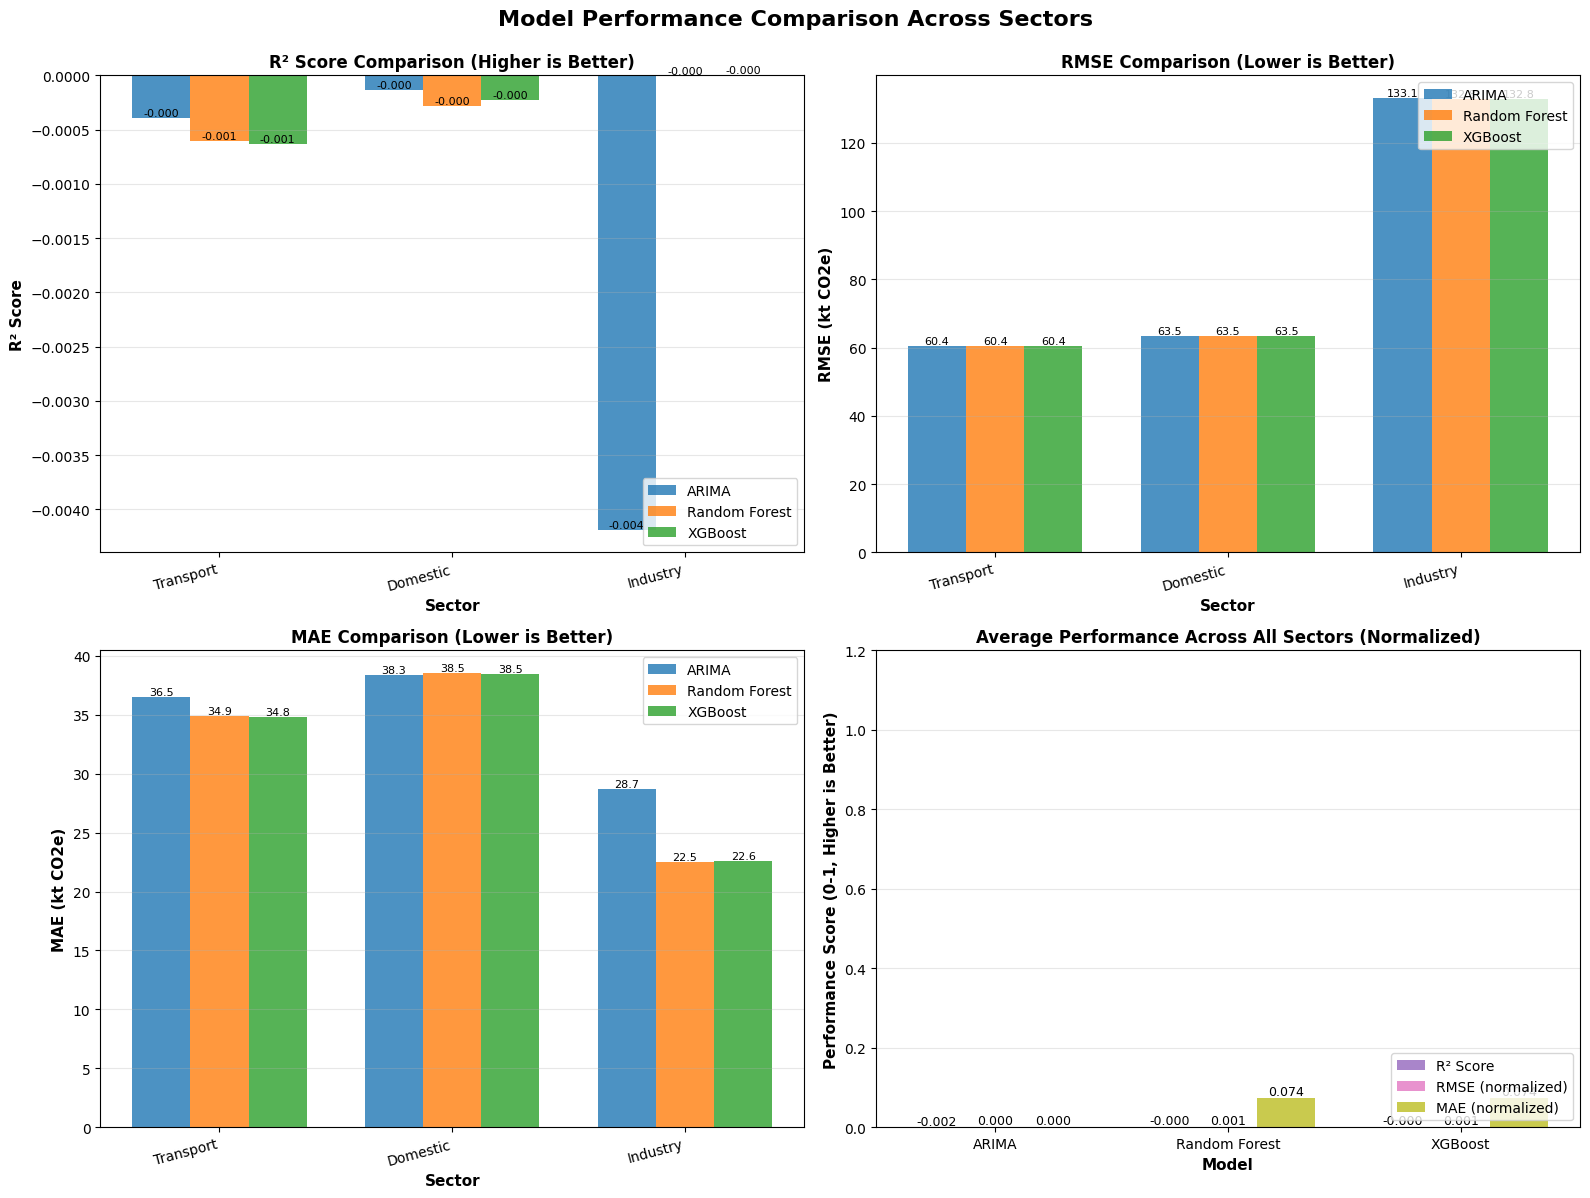

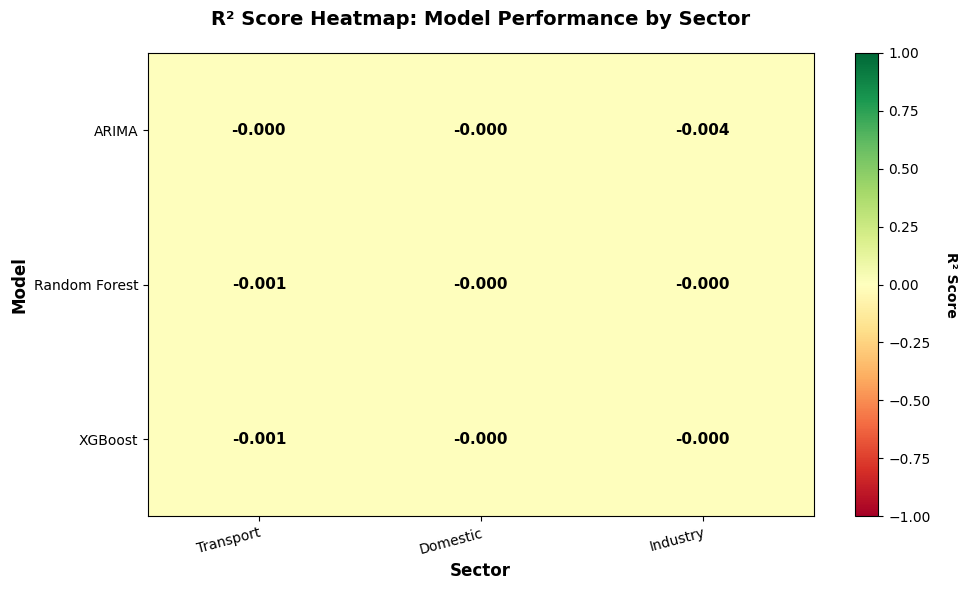


✓ Visualizations generated successfully!


In [11]:
# ============================================================================
# GRAPHICAL COMPARISON OF MODEL PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("VISUALIZING MODEL PERFORMANCE COMPARISON")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np

# Set up figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison Across Sectors', fontsize=16, fontweight='bold', y=0.995)

# ============================================================================
# PLOT 1: R² Score Comparison by Sector
# ============================================================================
ax1 = axes[0, 0]
sectors = perf_df['Sector'].values
x = np.arange(len(sectors))
width = 0.25

r2_arima = perf_df['ARIMA_R2'].values
r2_rf = perf_df['RF_R2'].values
r2_xgb = perf_df['XGB_R2'].values

bars1 = ax1.bar(x - width, r2_arima, width, label='ARIMA', color='#1f77b4', alpha=0.8)
bars2 = ax1.bar(x, r2_rf, width, label='Random Forest', color='#ff7f0e', alpha=0.8)
bars3 = ax1.bar(x + width, r2_xgb, width, label='XGBoost', color='#2ca02c', alpha=0.8)

ax1.set_xlabel('Sector', fontsize=11, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(sectors, rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# PLOT 2: RMSE Comparison by Sector
# ============================================================================
ax2 = axes[0, 1]
rmse_arima = perf_df['ARIMA_RMSE'].values
rmse_rf = perf_df['RF_RMSE'].values
rmse_xgb = perf_df['XGB_RMSE'].values

bars1 = ax2.bar(x - width, rmse_arima, width, label='ARIMA', color='#1f77b4', alpha=0.8)
bars2 = ax2.bar(x, rmse_rf, width, label='Random Forest', color='#ff7f0e', alpha=0.8)
bars3 = ax2.bar(x + width, rmse_xgb, width, label='XGBoost', color='#2ca02c', alpha=0.8)

ax2.set_xlabel('Sector', fontsize=11, fontweight='bold')
ax2.set_ylabel('RMSE (kt CO2e)', fontsize=11, fontweight='bold')
ax2.set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sectors, rotation=15, ha='right')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# PLOT 3: MAE Comparison by Sector
# ============================================================================
ax3 = axes[1, 0]
mae_arima = perf_df['ARIMA_MAE'].values
mae_rf = perf_df['RF_MAE'].values
mae_xgb = perf_df['XGB_MAE'].values

bars1 = ax3.bar(x - width, mae_arima, width, label='ARIMA', color='#1f77b4', alpha=0.8)
bars2 = ax3.bar(x, mae_rf, width, label='Random Forest', color='#ff7f0e', alpha=0.8)
bars3 = ax3.bar(x + width, mae_xgb, width, label='XGBoost', color='#2ca02c', alpha=0.8)

ax3.set_xlabel('Sector', fontsize=11, fontweight='bold')
ax3.set_ylabel('MAE (kt CO2e)', fontsize=11, fontweight='bold')
ax3.set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(sectors, rotation=15, ha='right')
ax3.legend(loc='upper right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# PLOT 4: Average Performance Across All Sectors
# ============================================================================
ax4 = axes[1, 1]
models = ['ARIMA', 'Random Forest', 'XGBoost']
avg_r2 = [avg_scores['ARIMA'][0], avg_scores['Random Forest'][0], avg_scores['XGBoost'][0]]
avg_rmse = [avg_scores['ARIMA'][1], avg_scores['Random Forest'][1], avg_scores['XGBoost'][1]]
avg_mae = [avg_scores['ARIMA'][2], avg_scores['Random Forest'][2], avg_scores['XGBoost'][2]]

x_models = np.arange(len(models))
width = 0.25

# Normalize RMSE and MAE to 0-1 scale for comparison with R² (inverted because lower is better)
max_rmse = max(avg_rmse)
max_mae = max(avg_mae)
norm_rmse = [1 - (r/max_rmse) for r in avg_rmse]
norm_mae = [1 - (m/max_mae) for m in avg_mae]

bars1 = ax4.bar(x_models - width, avg_r2, width, label='R² Score', color='#9467bd', alpha=0.8)
bars2 = ax4.bar(x_models, norm_rmse, width, label='RMSE (normalized)', color='#e377c2', alpha=0.8)
bars3 = ax4.bar(x_models + width, norm_mae, width, label='MAE (normalized)', color='#bcbd22', alpha=0.8)

ax4.set_xlabel('Model', fontsize=11, fontweight='bold')
ax4.set_ylabel('Performance Score (0-1, Higher is Better)', fontsize=11, fontweight='bold')
ax4.set_title('Average Performance Across All Sectors (Normalized)', fontsize=12, fontweight='bold')
ax4.set_xticks(x_models)
ax4.set_xticklabels(models, rotation=0)
ax4.legend(loc='lower right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1.2])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# ADDITIONAL VISUALIZATION: Heatmap of R² Scores
# ============================================================================
fig2, ax = plt.subplots(figsize=(10, 6))

# Prepare data for heatmap
heatmap_data = perf_df[['ARIMA_R2', 'RF_R2', 'XGB_R2']].values
heatmap_labels = ['ARIMA', 'Random Forest', 'XGBoost']

im = ax.imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(sectors)))
ax.set_yticks(np.arange(len(heatmap_labels)))
ax.set_xticklabels(sectors)
ax.set_yticklabels(heatmap_labels)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('R² Score', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(heatmap_labels)):
    for j in range(len(sectors)):
        text = ax.text(j, i, f'{heatmap_data[j, i]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=11)

ax.set_title('R² Score Heatmap: Model Performance by Sector', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualizations generated successfully!")

In [16]:
# ============================================================================
# COMPARISON: ARIMA vs SARIMA vs ARIMAX with Manual Tuning
# ============================================================================

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

print("="*80)
print("ARIMA vs SARIMA vs ARIMAX COMPARISON")
print("Manual Parameter Tuning for Each Sector")
print("="*80)

# ============================================================================
# MANUAL PARAMETER CONFIGURATION FOR TIME SERIES MODELS
# ============================================================================
time_series_params = {
    top_3_names[0]: {  # First sector (e.g., Transport)
        'arima_order': (3, 2, 1),
        'sarima_order': (3, 2, 1),
        'sarima_seasonal_order': (3, 2, 1, 4),  # (P, D, Q, s) - s=4 for potential 4-year cycle
        'arimax_order': (3, 2, 1)
    },
    top_3_names[1]: {  # Second sector (e.g., Domestic)
        'arima_order': (3, 2, 1),
        'sarima_order': (3, 2, 1),
        'sarima_seasonal_order': (3, 2, 1, 4),
        'arimax_order': (3, 2, 1)
    },
    top_3_names[2]: {  # Third sector (e.g., Industry)
        'arima_order': (3, 2, 1),
        'sarima_order': (3, 2, 1),
        'sarima_seasonal_order': (3, 2, 1, 4),
        'arimax_order': (3, 2, 1)
    }
}

print("\nManual Parameters Set:")
for sector, params in time_series_params.items():
    print(f"\n{sector}:")
    print(f"  ARIMA: order={params['arima_order']}")
    print(f"  SARIMA: order={params['sarima_order']}, seasonal_order={params['sarima_seasonal_order']}")
    print(f"  ARIMAX: order={params['arimax_order']} (with exogenous variables)")

# Helper function to create exogenous variables for ARIMAX
def create_exog_features(data):
    """Create exogenous variables for ARIMAX model"""
    df = data.copy()
    df = df.sort_values('Year').reset_index(drop=True)
    
    # Feature 1: Linear trend
    df['trend'] = np.arange(len(df))
    
    # Feature 2: Lagged emissions (1 year lag)
    df['lag_1'] = df['Carbon Emissions'].shift(1)
    
    # Feature 3: Moving average (3-year window)
    df['ma_3'] = df['Carbon Emissions'].rolling(window=3, min_periods=1).mean()
    
    # Fill NaN values (first rows)
    df['lag_1'] = df['lag_1'].fillna(df['Carbon Emissions'].iloc[0])
    
    return df[['trend', 'lag_1', 'ma_3']]

# Storage for results
ts_results = []
arima_ts_results = {}
sarima_ts_results = {}
arimax_ts_results = {}

# ============================================================================
# MODEL 1: ARIMA
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: ARIMA")
print("="*80)

for sector in top_3_names:
    print(f"\n{'─'*80}")
    print(f"Training ARIMA for Sector: {sector}")
    print(f"{'─'*80}")
    
    sector_data = sector_ts_data[sector].sort_values('Year').reset_index(drop=True)
    
    # Split data
    split_idx = int(len(sector_data) * 0.8)
    train = sector_data.iloc[:split_idx]
    test = sector_data.iloc[split_idx:]
    
    y_train = train['Carbon Emissions']
    y_test = test['Carbon Emissions']
    
    # Get parameters
    arima_order = time_series_params[sector]['arima_order']
    print(f"Using order: {arima_order}")
    
    try:
        model = ARIMA(y_train, order=arima_order).fit()
        print(f"✓ Model fitted (AIC: {model.aic:.2f})")
        
        predictions = model.forecast(steps=len(y_test))
        r2, rmse, mae = evaluate_model(y_test, predictions)
        
        print(f"  Performance: R² = {r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")
        
        arima_ts_results[sector] = {
            'R2': r2, 'RMSE': rmse, 'MAE': mae,
            'Order': arima_order, 'AIC': model.aic
        }
    except Exception as e:
        print(f"✗ Error: {str(e)[:100]}")
        arima_ts_results[sector] = {
            'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan,
            'Order': arima_order, 'AIC': np.nan
        }

# ============================================================================
# MODEL 2: SARIMA
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: SARIMA (Seasonal ARIMA)")
print("="*80)

for sector in top_3_names:
    print(f"\n{'─'*80}")
    print(f"Training SARIMA for Sector: {sector}")
    print(f"{'─'*80}")
    
    sector_data = sector_ts_data[sector].sort_values('Year').reset_index(drop=True)
    
    # Split data
    split_idx = int(len(sector_data) * 0.8)
    train = sector_data.iloc[:split_idx]
    test = sector_data.iloc[split_idx:]
    
    y_train = train['Carbon Emissions']
    y_test = test['Carbon Emissions']
    
    # Get parameters
    sarima_order = time_series_params[sector]['sarima_order']
    seasonal_order = time_series_params[sector]['sarima_seasonal_order']
    print(f"Using order: {sarima_order}, seasonal_order: {seasonal_order}")
    
    try:
        model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order).fit(disp=False)
        print(f"✓ Model fitted (AIC: {model.aic:.2f})")
        
        predictions = model.forecast(steps=len(y_test))
        r2, rmse, mae = evaluate_model(y_test, predictions)
        
        print(f"  Performance: R² = {r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")
        
        sarima_ts_results[sector] = {
            'R2': r2, 'RMSE': rmse, 'MAE': mae,
            'Order': sarima_order, 'Seasonal_Order': seasonal_order, 'AIC': model.aic
        }
    except Exception as e:
        print(f"✗ Error: {str(e)[:100]}")
        sarima_ts_results[sector] = {
            'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan,
            'Order': sarima_order, 'Seasonal_Order': seasonal_order, 'AIC': np.nan
        }

# ============================================================================
# MODEL 3: ARIMAX
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: ARIMAX (ARIMA with Exogenous Variables)")
print("="*80)

for sector in top_3_names:
    print(f"\n{'─'*80}")
    print(f"Training ARIMAX for Sector: {sector}")
    print(f"{'─'*80}")
    
    sector_data = sector_ts_data[sector].sort_values('Year').reset_index(drop=True)
    
    # Create exogenous features
    exog_features = create_exog_features(sector_data)
    print(f"Exogenous features: {list(exog_features.columns)}")
    
    # Split data
    split_idx = int(len(sector_data) * 0.8)
    train = sector_data.iloc[:split_idx]
    test = sector_data.iloc[split_idx:]
    
    y_train = train['Carbon Emissions']
    y_test = test['Carbon Emissions']
    exog_train = exog_features.iloc[:split_idx]
    exog_test = exog_features.iloc[split_idx:]
    
    # Get parameters
    arimax_order = time_series_params[sector]['arimax_order']
    print(f"Using order: {arimax_order}")
    
    try:
        model = SARIMAX(y_train, exog=exog_train, order=arimax_order).fit(disp=False)
        print(f"✓ Model fitted (AIC: {model.aic:.2f})")
        
        predictions = model.forecast(steps=len(y_test), exog=exog_test)
        r2, rmse, mae = evaluate_model(y_test, predictions)
        
        print(f"  Performance: R² = {r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")
        
        arimax_ts_results[sector] = {
            'R2': r2, 'RMSE': rmse, 'MAE': mae,
            'Order': arimax_order, 'AIC': model.aic
        }
    except Exception as e:
        print(f"✗ Error: {str(e)[:100]}")
        arimax_ts_results[sector] = {
            'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan,
            'Order': arimax_order, 'AIC': np.nan
        }

# ============================================================================
# CONSOLIDATED RESULTS
# ============================================================================
print("\n" + "="*80)
print("CONSOLIDATED RESULTS: ARIMA vs SARIMA vs ARIMAX")
print("="*80)

for sector in top_3_names:
    ts_results.append({
        'Sector': sector,
        'ARIMA_R2': arima_ts_results[sector]['R2'],
        'ARIMA_RMSE': arima_ts_results[sector]['RMSE'],
        'ARIMA_MAE': arima_ts_results[sector]['MAE'],
        'SARIMA_R2': sarima_ts_results[sector]['R2'],
        'SARIMA_RMSE': sarima_ts_results[sector]['RMSE'],
        'SARIMA_MAE': sarima_ts_results[sector]['MAE'],
        'ARIMAX_R2': arimax_ts_results[sector]['R2'],
        'ARIMAX_RMSE': arimax_ts_results[sector]['RMSE'],
        'ARIMAX_MAE': arimax_ts_results[sector]['MAE']
    })

ts_perf_df = pd.DataFrame(ts_results)
print("\nPerformance Summary:")
display(ts_perf_df)

# Calculate average performance
print("\n" + "="*80)
print("AVERAGE PERFORMANCE ACROSS ALL SECTORS")
print("="*80)

ts_avg_scores = {
    'ARIMA': ts_perf_df[['ARIMA_R2', 'ARIMA_RMSE', 'ARIMA_MAE']].mean().values,
    'SARIMA': ts_perf_df[['SARIMA_R2', 'SARIMA_RMSE', 'SARIMA_MAE']].mean().values,
    'ARIMAX': ts_perf_df[['ARIMAX_R2', 'ARIMAX_RMSE', 'ARIMAX_MAE']].mean().values
}

for model, scores in ts_avg_scores.items():
    print(f"\n{model}:")
    print(f"  Average R² = {scores[0]:.4f}")
    print(f"  Average RMSE = {scores[1]:.2f}")
    print(f"  Average MAE = {scores[2]:.2f}")

# Print parameter summary
print("\n" + "="*80)
print("PARAMETER SUMMARY")
print("="*80)
for sector in top_3_names:
    print(f"\n{sector}:")
    print(f"  ARIMA: {arima_ts_results[sector]['Order']}, AIC={arima_ts_results[sector].get('AIC', 'N/A'):.2f}" if not np.isnan(arima_ts_results[sector].get('AIC', np.nan)) else f"  ARIMA: {arima_ts_results[sector]['Order']}, AIC=N/A")
    print(f"  SARIMA: {sarima_ts_results[sector]['Order']} × {sarima_ts_results[sector]['Seasonal_Order']}, AIC={sarima_ts_results[sector].get('AIC', 'N/A'):.2f}" if not np.isnan(sarima_ts_results[sector].get('AIC', np.nan)) else f"  SARIMA: {sarima_ts_results[sector]['Order']} × {sarima_ts_results[sector]['Seasonal_Order']}, AIC=N/A")
    print(f"  ARIMAX: {arimax_ts_results[sector]['Order']}, AIC={arimax_ts_results[sector].get('AIC', 'N/A'):.2f}" if not np.isnan(arimax_ts_results[sector].get('AIC', np.nan)) else f"  ARIMAX: {arimax_ts_results[sector]['Order']}, AIC=N/A")

ARIMA vs SARIMA vs ARIMAX COMPARISON
Manual Parameter Tuning for Each Sector

Manual Parameters Set:

Transport:
  ARIMA: order=(3, 2, 1)
  SARIMA: order=(3, 2, 1), seasonal_order=(3, 2, 1, 4)
  ARIMAX: order=(3, 2, 1) (with exogenous variables)

Domestic:
  ARIMA: order=(3, 2, 1)
  SARIMA: order=(3, 2, 1), seasonal_order=(3, 2, 1, 4)
  ARIMAX: order=(3, 2, 1) (with exogenous variables)

Industry:
  ARIMA: order=(3, 2, 1)
  SARIMA: order=(3, 2, 1), seasonal_order=(3, 2, 1, 4)
  ARIMAX: order=(3, 2, 1) (with exogenous variables)

MODEL 1: ARIMA

────────────────────────────────────────────────────────────────────────────────
Training ARIMA for Sector: Transport
────────────────────────────────────────────────────────────────────────────────
Using order: (3, 2, 1)
✓ Model fitted (AIC: 851478.32)
  Performance: R² = -0.5341, RMSE = 74.22, MAE = 64.05

────────────────────────────────────────────────────────────────────────────────
Training ARIMA for Sector: Domestic
──────────────────────

,Sector,ARIMA_R2,ARIMA_RMSE,ARIMA_MAE,SARIMA_R2,SARIMA_RMSE,SARIMA_MAE,ARIMAX_R2,ARIMAX_RMSE,ARIMAX_MAE
0,Transport,-0.534073,74.224179,64.049240,-1.011752e+10,6.027808e+06,4.300140e+06,-0.465267,72.540554,62.135343
1,Domestic,-0.092203,67.625216,29.751417,-5.906266e+03,4.973364e+03,4.571336e+03,-0.041740,66.044498,32.217528
2,Industry,-0.009851,137.106485,16.457935,-1.114061e+02,1.446519e+03,1.073169e+03,-0.009837,137.105534,16.454998



AVERAGE PERFORMANCE ACROSS ALL SECTORS

ARIMA:
  Average R² = -0.2120
  Average RMSE = 92.99
  Average MAE = 36.75

SARIMA:
  Average R² = -3372507021.7497
  Average RMSE = 2011409.18
  Average MAE = 1435261.60

ARIMAX:
  Average R² = -0.1723
  Average RMSE = 91.90
  Average MAE = 36.94

PARAMETER SUMMARY

Transport:
  ARIMA: (3, 2, 1), AIC=851478.32
  SARIMA: (3, 2, 1) × (3, 2, 1, 4), AIC=872393.83
  ARIMAX: (3, 2, 1), AIC=851466.20

Domestic:
  ARIMA: (3, 2, 1), AIC=581610.90
  SARIMA: (3, 2, 1) × (3, 2, 1, 4), AIC=632077.91
  ARIMAX: (3, 2, 1), AIC=581609.59

Industry:
  ARIMA: (3, 2, 1), AIC=855911.67
  SARIMA: (3, 2, 1) × (3, 2, 1, 4), AIC=930527.04
  ARIMAX: (3, 2, 1), AIC=855917.65



VISUALIZING TIME SERIES MODEL PERFORMANCE COMPARISON


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. matplotlib.backends._backend_agg.RendererAgg(width: int, height: int, dpi: float)

Invoked with: 1323, 1180377458694, 100.0

<Figure size 1600x1200 with 4 Axes>

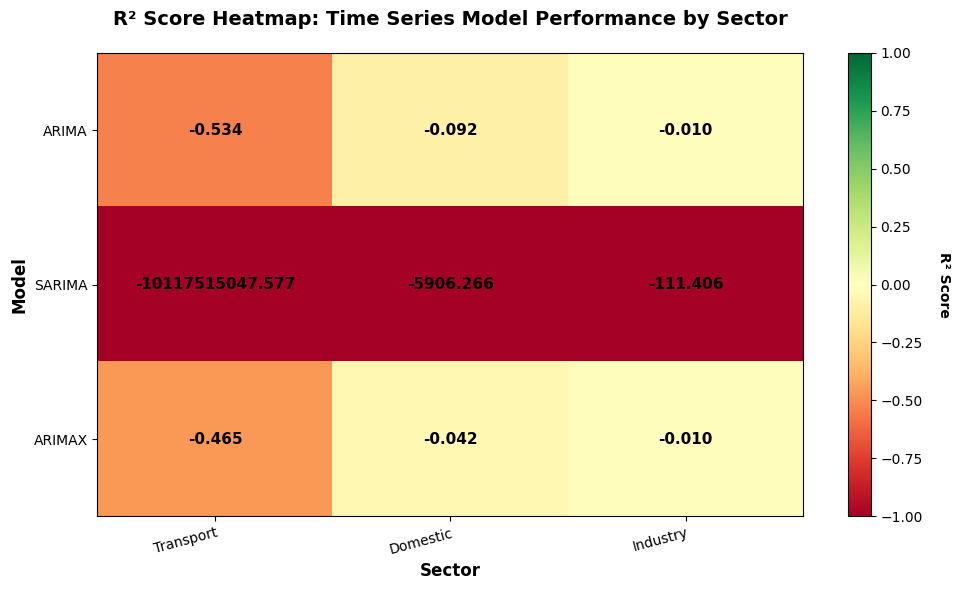

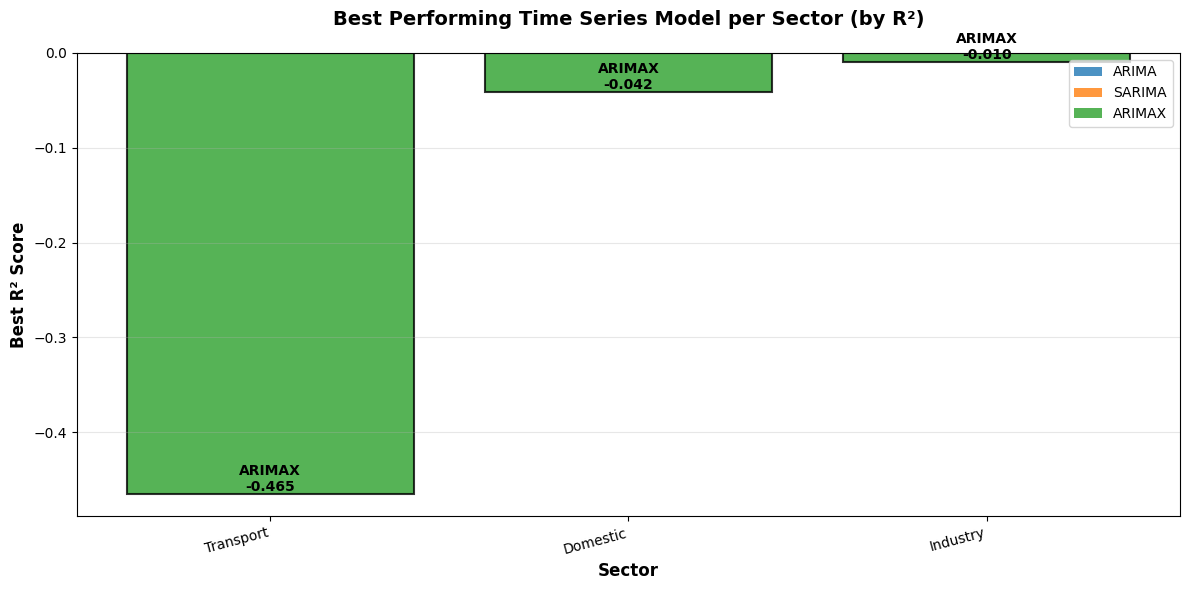


✓ Time series model visualizations generated successfully!

SUMMARY: Best Model per Sector
Transport: ARIMAX (R² = -0.4653)
Domestic: ARIMAX (R² = -0.0417)
Industry: ARIMAX (R² = -0.0098)


In [17]:
# ============================================================================
# GRAPHICAL COMPARISON: ARIMA vs SARIMA vs ARIMAX
# ============================================================================
print("\n" + "="*80)
print("VISUALIZING TIME SERIES MODEL PERFORMANCE COMPARISON")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np

# Set up figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Time Series Model Performance Comparison (ARIMA vs SARIMA vs ARIMAX)', 
             fontsize=16, fontweight='bold', y=0.995)

# ============================================================================
# PLOT 1: R² Score Comparison by Sector
# ============================================================================
ax1 = axes[0, 0]
sectors = ts_perf_df['Sector'].values
x = np.arange(len(sectors))
width = 0.25

r2_arima = ts_perf_df['ARIMA_R2'].values
r2_sarima = ts_perf_df['SARIMA_R2'].values
r2_arimax = ts_perf_df['ARIMAX_R2'].values

bars1 = ax1.bar(x - width, r2_arima, width, label='ARIMA', color='#1f77b4', alpha=0.8)
bars2 = ax1.bar(x, r2_sarima, width, label='SARIMA', color='#ff7f0e', alpha=0.8)
bars3 = ax1.bar(x + width, r2_arimax, width, label='ARIMAX', color='#2ca02c', alpha=0.8)

ax1.set_xlabel('Sector', fontsize=11, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(sectors, rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# PLOT 2: RMSE Comparison by Sector
# ============================================================================
ax2 = axes[0, 1]
rmse_arima = ts_perf_df['ARIMA_RMSE'].values
rmse_sarima = ts_perf_df['SARIMA_RMSE'].values
rmse_arimax = ts_perf_df['ARIMAX_RMSE'].values

bars1 = ax2.bar(x - width, rmse_arima, width, label='ARIMA', color='#1f77b4', alpha=0.8)
bars2 = ax2.bar(x, rmse_sarima, width, label='SARIMA', color='#ff7f0e', alpha=0.8)
bars3 = ax2.bar(x + width, rmse_arimax, width, label='ARIMAX', color='#2ca02c', alpha=0.8)

ax2.set_xlabel('Sector', fontsize=11, fontweight='bold')
ax2.set_ylabel('RMSE (kt CO2e)', fontsize=11, fontweight='bold')
ax2.set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sectors, rotation=15, ha='right')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# PLOT 3: MAE Comparison by Sector
# ============================================================================
ax3 = axes[1, 0]
mae_arima = ts_perf_df['ARIMA_MAE'].values
mae_sarima = ts_perf_df['SARIMA_MAE'].values
mae_arimax = ts_perf_df['ARIMAX_MAE'].values

bars1 = ax3.bar(x - width, mae_arima, width, label='ARIMA', color='#1f77b4', alpha=0.8)
bars2 = ax3.bar(x, mae_sarima, width, label='SARIMA', color='#ff7f0e', alpha=0.8)
bars3 = ax3.bar(x + width, mae_arimax, width, label='ARIMAX', color='#2ca02c', alpha=0.8)

ax3.set_xlabel('Sector', fontsize=11, fontweight='bold')
ax3.set_ylabel('MAE (kt CO2e)', fontsize=11, fontweight='bold')
ax3.set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(sectors, rotation=15, ha='right')
ax3.legend(loc='upper right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# PLOT 4: Average Performance Across All Sectors
# ============================================================================
ax4 = axes[1, 1]
models = ['ARIMA', 'SARIMA', 'ARIMAX']
avg_r2 = [ts_avg_scores['ARIMA'][0], ts_avg_scores['SARIMA'][0], ts_avg_scores['ARIMAX'][0]]
avg_rmse = [ts_avg_scores['ARIMA'][1], ts_avg_scores['SARIMA'][1], ts_avg_scores['ARIMAX'][1]]
avg_mae = [ts_avg_scores['ARIMA'][2], ts_avg_scores['SARIMA'][2], ts_avg_scores['ARIMAX'][2]]

x_models = np.arange(len(models))
width = 0.25

# Normalize RMSE and MAE to 0-1 scale for comparison with R² (inverted because lower is better)
max_rmse = max([r for r in avg_rmse if not np.isnan(r)])
max_mae = max([m for m in avg_mae if not np.isnan(m)])
norm_rmse = [1 - (r/max_rmse) if not np.isnan(r) else 0 for r in avg_rmse]
norm_mae = [1 - (m/max_mae) if not np.isnan(m) else 0 for m in avg_mae]
safe_r2 = [r if not np.isnan(r) else 0 for r in avg_r2]

bars1 = ax4.bar(x_models - width, safe_r2, width, label='R² Score', color='#9467bd', alpha=0.8)
bars2 = ax4.bar(x_models, norm_rmse, width, label='RMSE (normalized)', color='#e377c2', alpha=0.8)
bars3 = ax4.bar(x_models + width, norm_mae, width, label='MAE (normalized)', color='#bcbd22', alpha=0.8)

ax4.set_xlabel('Model', fontsize=11, fontweight='bold')
ax4.set_ylabel('Performance Score (0-1, Higher is Better)', fontsize=11, fontweight='bold')
ax4.set_title('Average Performance Across All Sectors (Normalized)', fontsize=12, fontweight='bold')
ax4.set_xticks(x_models)
ax4.set_xticklabels(models, rotation=0)
ax4.legend(loc='lower right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1.2])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# ADDITIONAL VISUALIZATION: Heatmap of R² Scores
# ============================================================================
fig2, ax = plt.subplots(figsize=(10, 6))

# Prepare data for heatmap
heatmap_data = ts_perf_df[['ARIMA_R2', 'SARIMA_R2', 'ARIMAX_R2']].values
heatmap_labels = ['ARIMA', 'SARIMA', 'ARIMAX']

im = ax.imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(sectors)))
ax.set_yticks(np.arange(len(heatmap_labels)))
ax.set_xticklabels(sectors)
ax.set_yticklabels(heatmap_labels)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('R² Score', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(heatmap_labels)):
    for j in range(len(sectors)):
        if not np.isnan(heatmap_data[j, i]):
            text = ax.text(j, i, f'{heatmap_data[j, i]:.3f}',
                          ha="center", va="center", color="black", fontweight='bold', fontsize=11)

ax.set_title('R² Score Heatmap: Time Series Model Performance by Sector', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# SIDE-BY-SIDE COMPARISON: Best Model per Sector
# ============================================================================
fig3, ax = plt.subplots(figsize=(12, 6))

# Determine best model per sector based on R²
best_models = []
for idx, row in ts_perf_df.iterrows():
    scores = {'ARIMA': row['ARIMA_R2'], 'SARIMA': row['SARIMA_R2'], 'ARIMAX': row['ARIMAX_R2']}
    best_model = max(scores, key=scores.get)
    best_models.append((row['Sector'], best_model, scores[best_model]))

sectors_best = [item[0] for item in best_models]
models_best = [item[1] for item in best_models]
scores_best = [item[2] for item in best_models]

# Color map for models
color_map = {'ARIMA': '#1f77b4', 'SARIMA': '#ff7f0e', 'ARIMAX': '#2ca02c'}
colors = [color_map[model] for model in models_best]

bars = ax.bar(range(len(sectors_best)), scores_best, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
ax.set_ylabel('Best R² Score', fontsize=12, fontweight='bold')
ax.set_title('Best Performing Time Series Model per Sector (by R²)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(sectors_best)))
ax.set_xticklabels(sectors_best, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels and model names
for i, (bar, model, score) in enumerate(zip(bars, models_best, scores_best)):
    height = bar.get_height()
    if not np.isnan(height):
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{model}\n{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[model], label=model, alpha=0.8) for model in ['ARIMA', 'SARIMA', 'ARIMAX']]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Time series model visualizations generated successfully!")
print("\n" + "="*80)
print("SUMMARY: Best Model per Sector")
print("="*80)
for sector, model, score in best_models:
    print(f"{sector}: {model} (R² = {score:.4f})")